## Python examples in Sambridge et al. (2022): Displacement seismogram inversion for source parameters

This Jupyter notebook contains python code to illustrate calculations made in 

Sambridge, Jackson & Valentine (2022), [Geophysical Inversion and Optimal Transport](https://doi.org/10.1093/gji/ggac151), *Geophysical Journal International*.

This notebook demonstrates calculations involving waveform inversion for source locatuon and cmt parameters. It produces components of Figures 9, 10, 11 & 12 of Sambridge et al. (2022).

Some results are computationally expensive and by default have been replaced with reading in results from pickle files. These are:
- calcualtion of wavefom misfit surfaces for Wasserstein and L2 since they involve repeated waveform calculations for many locations. 
- repeat locations from differing starting models

If executing the pickle file contained in this package an option below is provided to use *on the fly* mode, and then write your own pickle files for future use in *read results* mode.


### Optimal Transport libraries

This notebook makes use of the following python scripts:

- `loc_cmt_util.py` contains various utility plot routines used in this notebook, but also acts as an interface to two independent libraries: 

- `OTlib.py` containing the author's Optimal Transport calculation library for 1D and 2D densities fields together with derivatives.

- `FingerprintLib.py` containing routines required to calculate nearest distance fields and 2D densities for time series together with their derivatives of density field with respect to time series amplitude.

#### Seismogram Software pyprop8

This notebook makes use of Andrew Valentine's pyprop8 implementation of of the seismogram calculation algorithm set out in [O'Toole & Woodhouse (2011)](https://doi.org/10.1111/j.1365-246X.2011.05210.x), together with the source derivatives set out in [O'Toole, Valentine & Woodhouse (2012)](https://doi.org/10.1111/j.1365-246X.2012.05608.x). To run this notebook this package
needs to be installed separately. Instructions of how to do this appear [here](https://pypi.org/project/pyprop8/).



### Source location and centroid moment tensor inversion with $L_2$ and $W_2^2$

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyprop8 as pp
from pyprop8.utils import rtf2xyz,make_moment_tensor
from tqdm import tqdm 
import time as timer
from matplotlib import cm
from scipy.optimize import minimize
from libs import myGP as gp
import pickle as pickle
from libs import loc_cmt_util as cmt_util
from libs import loc_cmt_util_opt as cmt_util_opt
cmt_util_opt.init()

In [2]:
def recordresult(x):
    from libs import loc_cmt_util_opt

    mis = loc_cmt_util_opt.opt_history_data[-1][0]
    Mxyz = loc_cmt_util_opt.opt_history_data[-1][-1]
    index = len(loc_cmt_util_opt.opt_history_data)
    if(invopt['precon']):
        loc_cmt_util_opt.opt_history.append([x*invopt['mscal'],mis,index,Mxyz])
    else:
        loc_cmt_util_opt.opt_history.append([x,mis,index,Mxyz])
    return

------------

## Earth model

Velocity model is from table 1 of O'Toole et al. (2012).

This earth model was used by Kobayashi et al.
(2006) in their finite fault inversions of HRGPS data for the 2005 Fukuoka earthquake.

In [3]:
model_table1 = np.array([[0.1,3.2,2.0,2.1],[1.9,5.15,2.85,2.5],[3.0,5.5,3.2,2.6],[13.0,6.0,3.46,2.7],[14.0,6.7,3.87,2.8],[np.inf,7.7,4.3,3.3]])
model = pp.LayeredStructureModel(model_table1,interface_depth_form = False)
print(model)

------------------------------------------------------- z = 0.00 km
  vp = 3.20 km/s   vs = 2.00 km/s   rho = 2.10 g/cm^3
------------------------------------------------------- z = 0.10 km
  vp = 5.15 km/s   vs = 2.85 km/s   rho = 2.50 g/cm^3
------------------------------------------------------- z = 2.00 km
  vp = 5.50 km/s   vs = 3.20 km/s   rho = 2.60 g/cm^3
------------------------------------------------------- z = 5.00 km
  vp = 6.00 km/s   vs = 3.46 km/s   rho = 2.70 g/cm^3
------------------------------------------------------- z = 18.00 km
  vp = 6.70 km/s   vs = 3.87 km/s   rho = 2.80 g/cm^3
------------------------------------------------------- z = 32.00 km
  vp = 7.70 km/s   vs = 4.30 km/s   rho = 3.30 g/cm^3



## Seismic Source

Seismic source is 2005 Mw 6.6 Fukuoka earthquake. 

We use the CMT solution of the Global CMT catalogue (strike=302, dip=88, rake=-14, with $M_o = 0.93E19$ Nm.
1 Nm = 10,000,000.00 dyne cm.

We also use a symmetricl trapezoidal source time function with $T_{rise}=3, T_{rupt}=6$.

In [4]:
# set up seismic source
Mo = 0.93e19 # source moment in Nm
dynecm2moment = 1.0E-20 # Conversion factor from dyne-cm to moment argument value
Nm2moment = 1.0E-13 # Conversion factor from Nm to moment argument value
sourceLat = 0.
sourceLong = 0.
source = pp.PointSource(0.,0.,10.,rtf2xyz(make_moment_tensor(302,88,-14,Mo*Nm2moment,0,0)),np.zeros((3,1)),0.0)

## Receiver Network

Test set of stations similar to Figure 3 of O'Toole et al. (2012).

Here we input an irregular network of stations locations using the *ListofReceivers* routine. 

In [5]:
xlocations_all = np.array([10.,30.,50.,-15.,8.,25.,-25.,55.,80.,75.,-70.])
ylocations_all = np.array([-75.,-77.,-70.,-50.,-46.,-42.,-25.,-26.,-23.,-5.,30.])
xlocations = xlocations_all
ylocations = ylocations_all
nr = 11 # Number of receivers
nc = 3 # Number of components
xtrue,ytrue,ztrue = 1., 1., 20. # true source location
mtrue = np.array([xtrue,ytrue,ztrue])

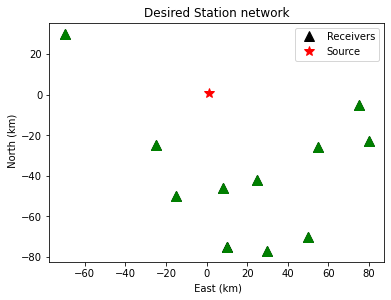

In [6]:
# plot actual station locations
s = (xlocations,ylocations)
s_a = (xlocations_all,ylocations_all)
fig, ax = plt.subplots(figsize=(6,6))
plt.subplot(111,aspect='equal')
plt.title("Desired Station network")
plt.plot(s_a[0][0],s_a[1][0],'k^',label='Receivers',markersize=10)
plt.plot(s_a[0],s_a[1],'k^',markersize=10)
plt.plot(s[0],s[1],'g^',markersize=10)
plt.xlabel(' East (km)')
plt.ylabel(' North (km)')
plt.plot(xtrue,ytrue,'r*',label='Source',markersize=10)
plt.legend()
plt.show()

These are the source station geometry seen in Figure 9 of Sambridge et al. (2022). 

Note zero frequency displacement seismograms, refereed to as GPS seismograms by O'Toole et al. (2012).

## Observed displacement seismograms

Calculate displacement seismograms from true location of source and then add correlated Gaussian noise. This is then used as `data' below.

In [7]:
# calculate noiseless displacement seismograms of true solution
nt = 61                       # Number of timesteps
timestep = 1.0                # time spacing
prop8data = {'model':model,'sdrm':[302,88,-14,Mo],'recx':xlocations,'recy':ylocations} # dictionary of prop8data
ta = timer.time()
t, sdata_nonoise = cmt_util.prop8seis(xtrue,ytrue,ztrue,prop8data)
tprop = timer.time() - ta
print(' Time taken for reference seismograms: ',tprop)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 34.32it/s]

 Time taken for reference seismograms:  1.451436996459961


### Calculation of seismogram noise
The Gaussian Process, GP, code `Createcurve` has by default a squared exponential GP with fixed amplitude of 0.2, defined over a 6s time window. 

The `corr` correlation value is interpreted relative to this 6s time window. So `corr=0.5` produces a Gaussian process with a time correlation of $\sigma_t = 0.5/6 * \Delta t$, where $\Delta t$ is the time window that it is used over. In the example below $\Delta t = 60 s$, and so $\sigma_t = 5 s$.

For `sigma_amp=0.6` the amplitude of the second Gaussian noise process becomes $A=0.6*0.2*f = 0.12*f$, which is 12% of the maximum amplitude in each window.

For `sigma_amp=0.2` the amplitude of the second Gaussian noise process becomes $A=0.3*0.2*f = 0.06*f$, which is 6% of the maximum amplitude in each window.

In [8]:
# add noise to seismograms
sigma_cor = 0.05 # noise correlation length value
sigma_amp = 0.3 # noise amplitude scale factor (This results in 0.3*0.2=6% amplitude)
np.random.seed(61254557) 
sdata_noise = np.zeros_like(sdata_nonoise)
sigma = np.zeros((nr,nc))
for i in range(nr):
    for j in range(nc):
        sig = sdata_nonoise[i,j,:]
        f = np.max(np.abs(sig))
        f = np.max(sig)-np.min(sig) 
        xc,yc = gp.Createcurve(0,nx=len(sig),corr=sigma_cor) # create a GP with amplitude 0.2 and time window +-3 s.
        sdata_noise[i,j,:] = sig*(1.+yc*sigma_amp*f) # This was used in the first paper examples
        sdata_noise[i,j,:] = sig +yc*sigma_amp*f     # This is a fixed amplitude noise relative to maximum window amplitude
        sigma[i,j] = np.std(yc*sigma_amp) # Calculate actual standard deviation of noise relative to maximum seismogram amplitude 

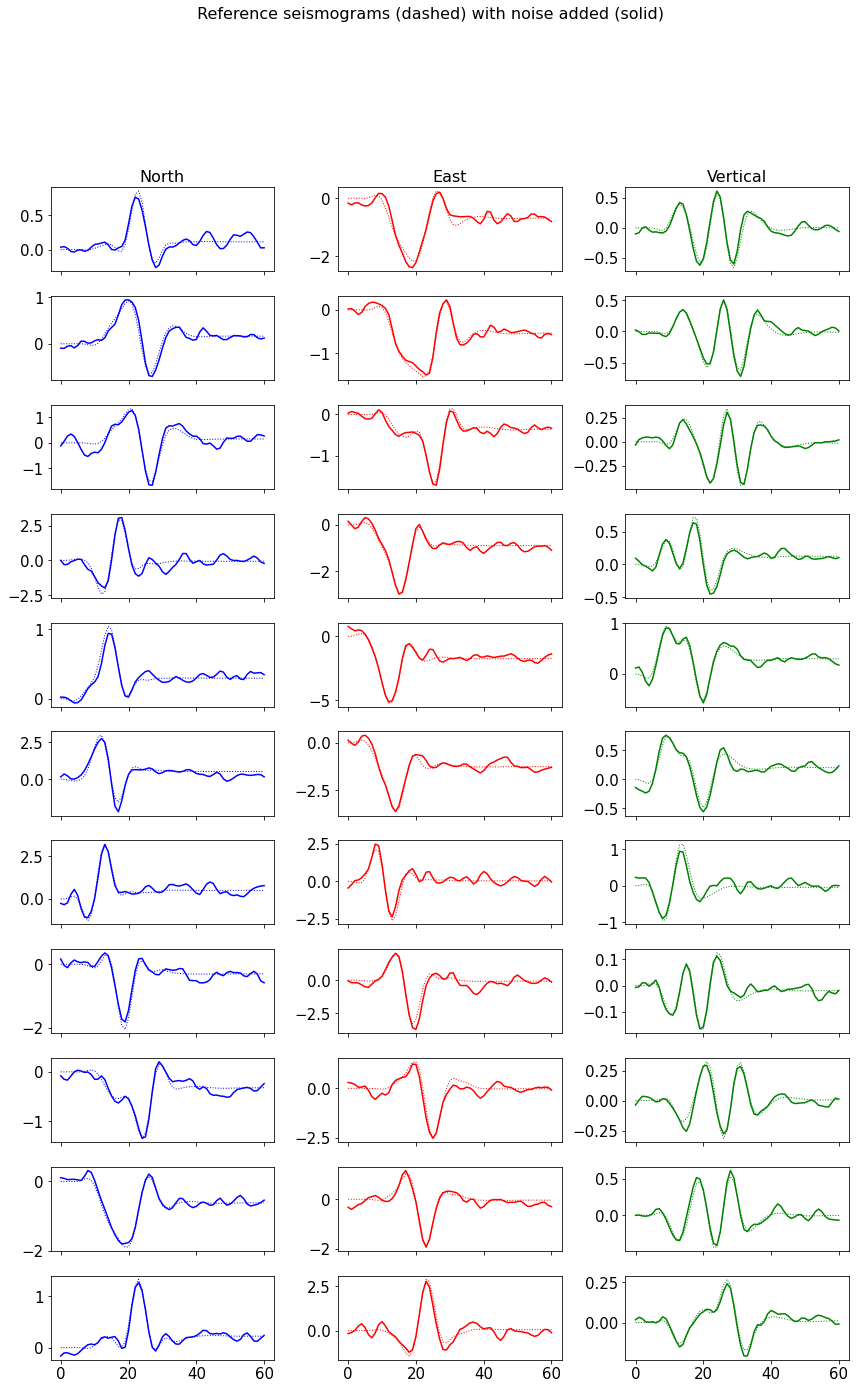

In [9]:
cmt_util.plotseis(sdata_noise,t,sdata_nonoise,title=' Reference seismograms (dashed) with noise added (solid)',filename='Figures/Best_fit.pdf')

This produces the noisy waveforms a subset of which are shown in Figure 10 of Sambridge et al. (2022). 

## Choose data set

In [10]:
#prop8data['obs_seis'] = sdata_nonoise # noiseless seismogram data
prop8data['obs_seis'] = sdata_noise   # noisy seismogram data

------

## Iterative source location and moment tensor inversion

Now we set up and solve a source location problem by minimizing seismogram misfit.

### Setup for inversion

This cell makes all the choices necessary to define the inversion problem being solved. The default is to perform a location only inversion (`invopt['loc']  = True` `invopt['cmt']  = False`) and with the Wasserstein misfit function (`invopt['mistype'] = 'OT'`).

Some other choices are:
- To use an $L_2^2$ waveform misfit set `invopt['mistype'] = 'L2'`.
- To include CMT parameters set `invopt['cmt'] = True`.
- To calculate either the $W_2^2$ or the $L_2^2$ misfit surfaces set `calcgridmisfit = True` (Otherwise read in results).  
- To calculate repeated optimisations from different starting positions set `repeatoptimisations = True` (Otherwise read in results).  


In [11]:
# setup inversion options. Controls type of problem to be solved as well as minimizer details.
invopt,OTdata  = {},{}
invopt['loc']  = True              # switch for inverting for source location parameters
invopt['cmt']  = False              # switch for inverting for CMT parameters
#invopt['mistype'] = 'L2'            # style of misfit function 'L2' for L2-norm between waveforms;'OT' for Wasserstein misfit based on 2D seismogram fingerprints.
invopt['mistype'] = 'OT'            # style of misfit function 'L2' for L2-norm between waveforms;'OT' for Wasserstein misfit based on 2D seismogram fingerprints.
OTdata['plambda'] = 0.04            # If using OT: set density scale parameter for predicted seismogram windows
OTdata['olambda'] = 0.04            # If using OT: set density scale parameter for observed seismogram windows
OTdata['distfunc']='W2'             # Distance function type when using OT (W1 for p=1 Wasserstein; W2 for p=2 Wasserstein)
OTdata['Wopt'] = 'Wavg'             # If using OT: 'Wavg' = minimize average of Wasserstein distances between marginals
                                    #               'Wt'  = minimize Wasserstein distance between time marginals
                                    #               'Wu'  = minimize Wasserstein distance between amplitude marginals
invopt['precon'] = False            # use preconditioning of model space (rescale model parameters to approximately equalize their influence on the misfit)
locprecon = np.array([10.,10.,20.]) # source location for gradient preconditioning  (only used if cmt and precon is True)
# plotting and IO
plotmisfit = True                   # Plot contoured slices through the misfit function
calcgridmisfit = False              # Calculate 3D misfit grid here (True and slow) or read in misfit grid from picklefile (False and fast)
repeatoptimisations = False         # Perform repeat optimisations from different starting locations (True and slow) or read them in from pickle (False and fast)
writepicklefile = False             # write pickle file with all results (Only makes sense if they have been calculated internally rather than read in)


#### Reading and writing pickle files

Here pickle files are provided for convenience to avoid lengthy run times. If reading and executing the pickle file distributed with this package is not desired, this may be avoided using the settings in the next cell to instead overwrite the pickle file with local calculations. This will, however, take some time.

To perform calculations internally and write your own pickle execute the next cell.

In [12]:
# perform calculations internally
if(False):
    calcgridmisfit = True              # Calculate 3D misfit grid here (True and slow) or read in misfit grid from picklefile (False and fast)
    repeatoptimisations = True         # Perform repeat optimisations from different starting locations (True and slow) or read them in from pickle (False and fast)
    writepicklefile = True             # write pickle file with all results (Only makes sense if they have been calculated internally rather than read in)


#### Preconditioning when inverting for both location and CMT parameters 

Note that when inverting for both location and CMT values, parameters have different dimensions and scales, some, e.g. Moment tensor components are far larger than the others, e.g. source location. This means that in turn gradient components can vary greatly between different unknowns, and since we are using a gradient based optimizer this in turn can have a significant influence on convergence. It makes sense then to allow for pre-conditioning, which means that the optimisation is carried out in a **rescaled** model parameter space. Here we simply decide on a set of scaling parameters for each variable and multiply the model parameters by that vector so that all optimisations are performed in that rescaled space. 

Ideally we would prefer all model parameters to be roughly the same size. This option is turned on by setting `invopt['precon'] = True` and scaling of model parameters is given by the values in `invopt['mscal']`, which is calculated automatically in a cell below.


This is a reference set up I have used for inversion of location and CMT parameters.


In [13]:
# set up starting model for optimisation
mstart = np.array([40.,40.,10.])      # Starting model (used in paper)
if(invopt['cmt']): 
    mstart = np.array([-40.,-40.,40.])      # Starting model
    invopt['precon'] = True                 # use preconditioning of model space 
    locprecon = np.array([10.,10.,20.])     # source location for gradient preconditioning  (only used if cmt and precon is True)


#### Output filenames

Set up filenames for pickles files to either read in previous results or calculate them and write out.

In [14]:
#pickle files names with previous results for display
readpicklefilenameOT = 'pickles/OT_loc.pickle' # read this pickle file for previous OT calculations (used if calcgridmisfit is False) 
readpicklefilenameL2 = 'pickles/L2_loc.pickle'                       # read this pickle file for previous L2 calculations (used if calcgridmisfit is False)
readpicklefilenameOTcmt = 'pickles/OT_loc_cmt.pickle' # read this pickle file for previous OT calculations and inverting for cmt
readpicklefilenameL2cmt = 'pickles/L2_loc_cmt.pickle' # read this pickle file for previous L2 calculations and inverting for cmt


In [15]:
# setup inversion options dictionary 
# If using OT: set density scale parameter for observed seismogram windows

obs_grids = cmt_util.buildFingerprintwindows(t,prop8data['obs_seis'])                                             # set up Fingerprint windows about each waveform
OTdata['obs_grids01'] = cmt_util.buildFingerprintwindows(t,prop8data['obs_seis'],u0=0.,u1=1.0)                    # set up Fingerprint windows about each waveform
wfobs, wfobs_target = cmt_util.BuildOTobjfromWaveform(t,prop8data['obs_seis'],obs_grids,OTdata,lambdav=OTdata['olambda']) # build observed data object for OT calculations containing all waveforms
OTdata['wfobs'] =wfobs
OTdata['wfobs_target']=wfobs_target
OTdata['obs_grids'] = obs_grids # fingerprint window and grid used for observations
mtrue = cmt_util.setmref(invopt,source,mtrue)
invopt['mref'] = mtrue
optdata = {'invopt':invopt,'OTdata':OTdata,'prop8data':prop8data}


In [16]:
# set up starting model for optimisation
mstart = np.array([40.,40.,10.])      # L2 fails with 5% Gausian noise; OT succeeds (used in paper)
if(invopt['cmt']): 
    mstart = np.array([-40.,-40.,40.])      # L2 fails and OT converges
    invopt['precon'] = True                 # use preconditioning of model space 
    locprecon = np.array([10.,10.,20.])     # source location for gradient preconditioning  (only used if cmt and precon is True)


In [17]:
# perform some preliminary work now we have starting model

if(invopt['cmt']): # set initial CMT solution to best fit at starting model
    mstart = np.append(mstart,cmt_util.Moment_LS([mstart[0],mstart[1],mstart[2]],prop8data))

if(invopt['precon']): # turn on preconditioning of model space 
    invopt['mprecon'] = [locprecon[0],locprecon[1],locprecon[2]]
    # Note that we cannot set the preconditioning location to the same model as the CMT solution for L2 because the gradients will be near zero, which damages the preconditioning (divide by near zero)
    invopt['precontype'] = 'gradient' # precondition model parameters using gradient of the misfit at a location
    invopt['precontype'] = 'constant' # precondition model parameters using a constant
    if(invopt['precontype']=='gradient'): # gradient preconditining
        mprecon = np.append(invopt['mprecon'],cmt_util.Moment_LS([invopt['mprecon'][0],invopt['mprecon'][1],invopt['mprecon'][2]],prop8data)) # set model used for preconditioning to mprecon model
        w,dw = cmt_util.optfunc(mprecon,optdata,precon=False) # use  gradient for preconditioning
    elif(invopt['precontype']=='constant'):
        dw = np.append(np.ones(3)/60.,np.ones(6)/(Mo*Nm2moment)) # set model used for preconditioning to start model
    invopt['mscal'] = 1./np.abs(dw)    
    mstartp = mstart/invopt['mscal'] # preconditioned starting model 

else:
    invopt['mscal'] = np.ones_like(mstart)
    mstartp = mstart                  # unpreconditioned starting model

optdata = {'invopt':invopt,'OTdata':OTdata,'prop8data':prop8data} # update inversion options dictionary
        

In [18]:
#Print some information about True solution
if(invopt['loc']): print(' True source location =',mtrue[:3])
if(invopt['loc'] and invopt['cmt']): print(' True source moment tensor =\n',mtrue[3:])
mis_true,dW = cmt_util.optfunc(mtrue,optdata,precon=False) # test opt func at True location
if(invopt['mistype']=='L2'):print('\n Waveform L2 misfit at true source location =',mis_true)
if(invopt['mistype']=='OT'):print('\n Waveform W misfit at true source location =',mis_true)

 True source location = [ 1.  1. 20.]

 Waveform W misfit at true source location = 0.008110338636587186


------

### Set up starting model for optimisation and predicted seismograms

 Waveform W misfit at start source location = 0.19507914996049122


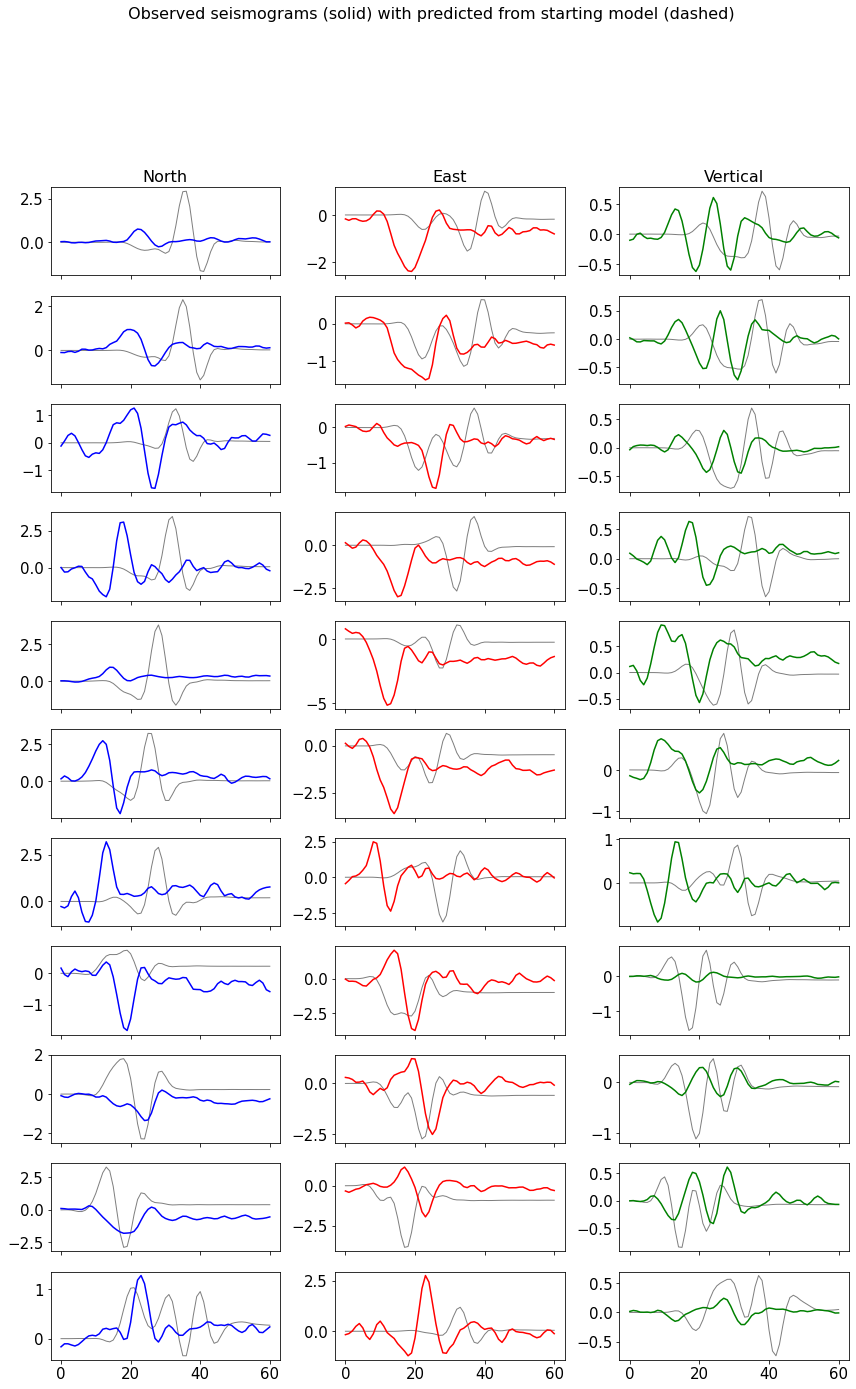

In [19]:
# calculate and plot observed and predicted seismograms for starting model
mis_start,d,t,spred_start = cmt_util.optfunc(mstart,optdata,returnseis=True,precon=False) # Calculate misfit for reference source
if(invopt['mistype']=='L2'):print(' Waveform L2 misfit at start source location =',mis_start)
if(invopt['mistype']=='OT'):print(' Waveform W misfit at start source location =',mis_start)
# plot observed and predicted seismograms from starting model
cmt_util.plotseis(prop8data['obs_seis'],t,splot2=spred_start,filename='Figures/waveform_start.pdf',title=' Observed seismograms (solid) with predicted from starting model (dashed)')

This produces the waveform fits a subset of which are shown in Figure 10 of Sambridge et al. (2022). 

#### Calculate and plot fingerprints for observed and predicted seismograms for starting model at chosen receiver

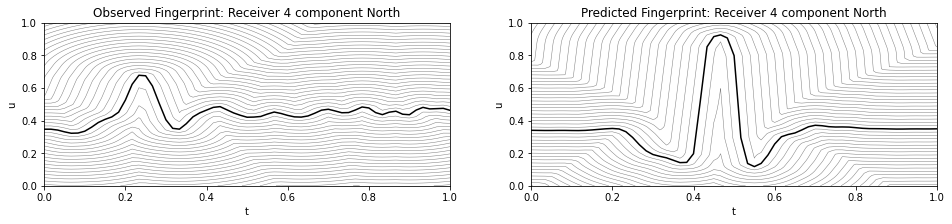

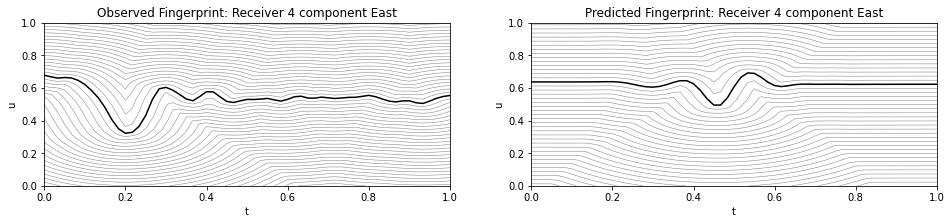

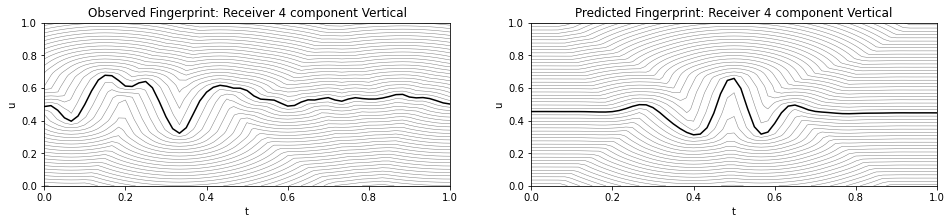

In [20]:
# plot selected waveform fingerprints
if(invopt['mistype']=='OT'):
    misfitp,d,wfobsout,wfpred,wfp_source,wf0_target = cmt_util.optfunc_OT(mstart,optdata,returnwobj=True,precon=False) # Calculate seismograms and misfit for reference source
    i = 4 # choose receiver
    lab = ['North','East','Vertical']
    for j in range(3):
        textleft = 'Observed Fingerprint: Receiver '+str(i)+' component '+lab[j]
        textright = 'Predicted Fingerprint: Receiver '+str(i)+' component '+lab[j]
        file = 'Figures/Seis_fingerprints_'+str(i)+'_'+str(j)+'.pdf'
        cmt_util.fp.plot_2LS(wfobsout[i][j],wfpred[i][j],textleft,textright,'black','grey',filename=file,ncon=10,fxsize=16,fysize=3) 

### Misfit minimization

Use L-BFGS-B gradient minimization for source location.

In [21]:
if(invopt['loc']): print('\n Inverting for source location')
if(invopt['cmt']): 
    print(' Inverting for moment tensor using gradient optimisation ')
elif(invopt['cmt']): 
    print(' Inverting for moment tensor using linear theory')
print(' Dimension of parameter space :',len(mstartp))
if(invopt['precon']): 
    print(' Gradient preconditioning being used about point',invopt['mprecon'])
if(invopt['mistype']=='OT'): print(' Misfit function: ',OTdata['Wopt'])
if(invopt['mistype']=='L2'): print(' Misfit function: L2')
print(' Starting source location: ',mstart[:3])
    
print('\n Running optimization.....\n')
time0 = timer.time()
    
if(invopt['loc'] and not invopt['cmt']): # only inverting for location with fixed cmt

    cmt_util_opt.opt_history = [mstart,mis_start,-1]
    
    # start inversion

    # perform optimisation over either W0, W1 or their average
    opt = minimize(cmt_util.optfunc, mstartp, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
          options={'disp': True,'maxiter': 500},callback=recordresult)
    
    print(opt)
    sol = opt.x
    if(invopt['precon']): sol = opt.x*invopt['mscal']

elif(invopt['loc'] and invopt['cmt']): # inverting for cmt and location

    cmt_util_opt.opt_history = [mstart,mis_start,-1]

    # start inversion

    opt = minimize(cmt_util.optfunc, mstartp, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
        options={'disp': True,'maxiter': 500},callback=recordresult)
            
    print(opt)
    sol = opt.x
    if(invopt['precon']): sol = opt.x*invopt['mscal']
    
elif(invopt['cmt']): # only inverting for CMT solution with fixed location
    
    # start inversion

    Mxyz = cmt_util.Moment_LS([xtrue,ytrue,ztrue],optdata[0])
    Mxyz = cmt_util.buildMxyzfromupper(Mxyz)
    
    print (' Mxyz solution: \n',Mxyz)

time_opt = timer.time() - time0

mis_final = opt.fun
print('\n Misfit start   :',mis_start)
print(' Misfit final     :',mis_final)
print(' Misfit true      :',mis_true)
r=np.array(mtrue[:3])-sol[:3]
print(' Distance to true :',np.sqrt(np.dot(r,r)))



 Inverting for source location
 Dimension of parameter space : 3
 Misfit function:  Wavg
 Starting source location:  [40. 40. 10.]

 Running optimization.....



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95079D-01    |proj g|=  3.34624D-03

At iterate    1    f=  1.20346D-01    |proj g|=  2.33693D-03

At iterate    2    f=  1.32115D-02    |proj g|=  2.02371D-03

At iterate    3    f=  9.62034D-03    |proj g|=  1.85847D-03

At iterate    4    f=  6.49296D-03    |proj g|=  2.65406D-04

At iterate    5    f=  6.34525D-03    |proj g|=  1.36456D-04

At iterate    6    f=  6.31686D-03    |proj g|=  6.28889D-05

At iterate    7    f=  6.31455D-03    |proj g|=  9.01884D-06

      fun: 0.0063143903573264545
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.03368043e-06, 4.31192952e-06, 3.76905963e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 8
     njev: 15
   status: 0
  success: True
        x: array([ 0.60155081,  1.90710772, 21.90

In [22]:
if(invopt['cmt']):cmt_util.printanalysis(sol,opt,mtrue,mstart,mis_start,mis_true,prop8data,sdata_nonoise)

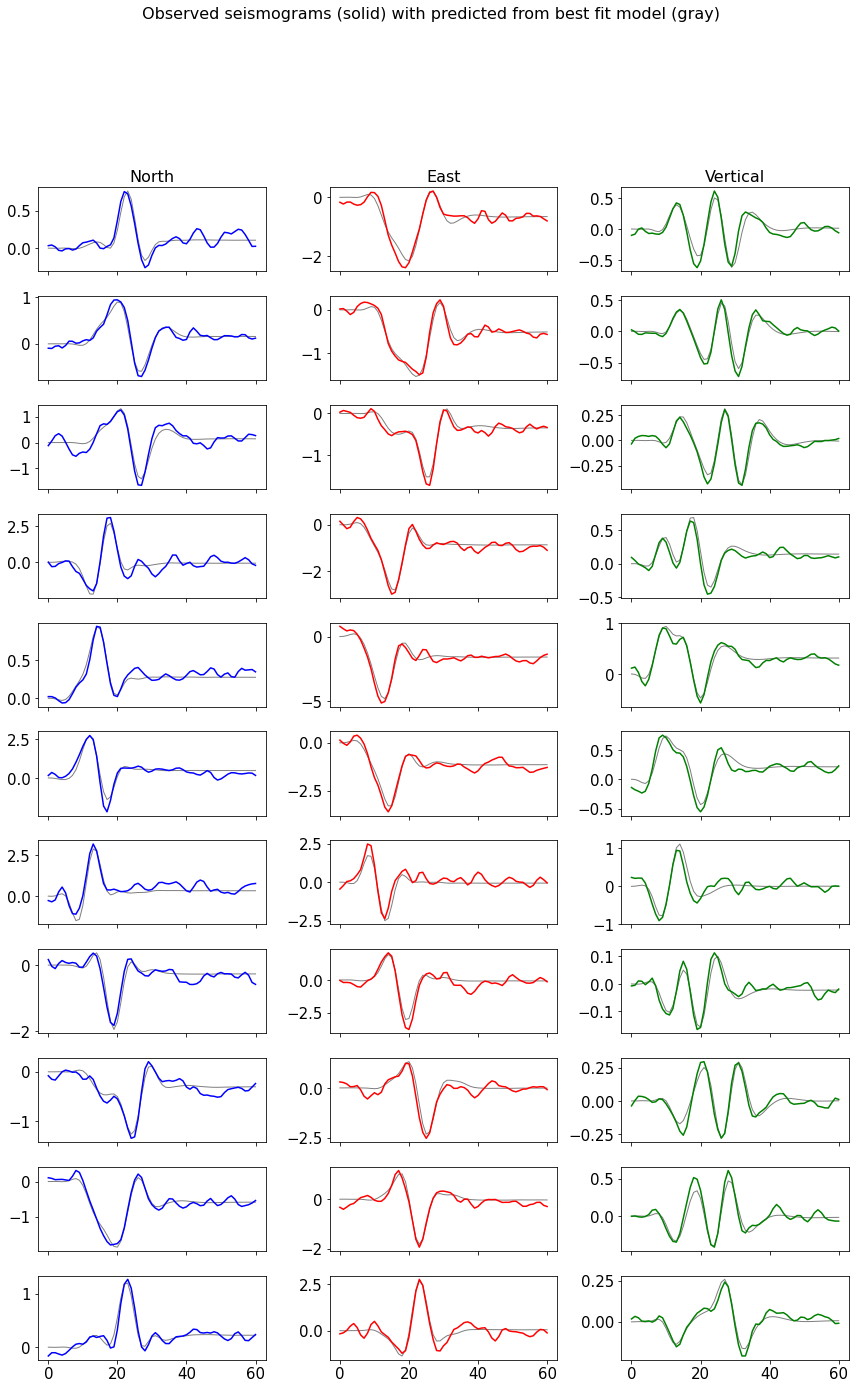

In [23]:
# calculate and plot observed and predicted seismograms
mfinal,dmfinal,t,spred_final = cmt_util.optfunc(sol,optdata,returnseis=True,precon=False)
cmt_util.plotseis(prop8data['obs_seis'],t,splot2=spred_final,title=' Observed seismograms (solid) with predicted from best fit model (gray)',filename='Figures/seis_final.pdf')


Observations with best fit seismograms.

In [24]:
if(True):
    # get some compute times for reference
    print('\nSome reporting statistics: \n')
    print('Size of fingerprint field: Nt=',wfobs[0][0].ntg,' Nu =',wfobs[0][0].nug,'Lambda: ',wfobs[0][0].lam)
    print('Time taken for distance field',wfobs[0][0].tcalc_fp)
    print('Time taken for density field',wfobs[0][0].tcalc_pdf)
    print('Number of iterations during minimization',opt.nit)
    print('Number of misfit evaluations during minimization',opt.nfev)
    #print('Number of Jacobian evaluations during minimization',opt.njev)
    print('Time taken for minimization:', time_opt)
    print('Error in solution location:',np.sqrt(np.dot(opt.x[:3]-mtrue[:3],opt.x[:3]-mtrue[:3])))



Some reporting statistics: 

Size of fingerprint field: Nt= 61  Nu = 79 Lambda:  0.04
Time taken for distance field 0.015046834945678711
Time taken for density field 2.8848648071289062e-05
Number of iterations during minimization 8
Number of misfit evaluations during minimization 15
Time taken for minimization: 35.99283194541931
Error in solution location: 2.147644037160037


### Plot contour map of misfit and solution

In [25]:
if( not calcgridmisfit):
    if(invopt['mistype']=='OT'):po = cmt_util.readpickle(readpicklefilenameOT)
    if(invopt['mistype']=='L2'): po = cmt_util.readpickle(readpicklefilenameL2)
    xlim,ylim,zlim = po['xlim'],po['ylim'],po['zlim']
    nx,ny,nz = po['nx'],po['ny'],po['nz']
    xg,yg,zg = po['xg'],po['yg'],po['zg']
    xgrid, ygrid = np.meshgrid(xg,yg)    # discrete source location (X,Y) parameter space
else:
    # set up parameter space
    xlim = [-60.,60.]                    # xlimits of parameter space for source location
    ylim = [-60.,60.]                    # ylimits of parameter space for source location
    zlim = [10.,30.]                     # zlimits of parameter space for source location
    nx,ny,nz = 21,21,4                   # discretization of (x,y,z) location parameter space for source location
    xg = np.linspace(xlim[0],xlim[1],nx) # discrete x-axis of source location parameter space
    yg = np.linspace(ylim[0],ylim[1],ny) # discrete y-axis of source location parameter space
    xgrid, ygrid = np.meshgrid(xg,yg)    # discrete source location (X,Y) parameter space
    zg = np.array([10.,20.,30.,40.])     # discrete z-axis of source location parameter space

In [26]:
# map misfit over parameter space (optionally do the calculation or read in the result)
misfitgrid = []
if(calcgridmisfit):
    if(plotmisfit and invopt['mistype']=='OT'):
        misfitgrid_t = np.zeros((nz,nx,ny))
        misfitgrid_u = np.zeros((nz,nx,ny))
        ta = timer.time()
        for k,z in enumerate(zg):
            for i,x in enumerate(tqdm(xg)):
                for j,y in enumerate(yg):
                    [misfitgrid_t[k,j,i],misfitgrid_u[k,j,i]],d = cmt_util.optfunc([x,y,z],optdata,return2W=True,precon=False)
        tsearch = timer.time() - ta
        print(' Time taken for grid search: ',tsearch)
        misfitgrid = [misfitgrid_t,misfitgrid_u]
    elif(plotmisfit):
        misfitgrid = np.zeros((nz,nx,ny))
        ta = timer.time()
        for k,z in enumerate(zg):
            for i,x in enumerate(tqdm(xg)):
                for j,y in enumerate(yg):
                    misfitgrid[k,j,i],d = cmt_util.optfunc([x,y,z],optdata,precon=False)
        tsearch = timer.time() - ta
        print(' Time taken for grid search: ',tsearch)
else:
    misfitgrid = po['misfitgrid'] # Assumes input pickle is consistent with mistype etc. 

In [27]:
# filenames of plots and pickles files
rootname = 'Figures/misfit_solution_'
fileformat = '.pdf'
if(invopt['cmt']): rootname = 'Figures/misfit_solution_cmt_'
if(invopt['mistype']=='OT'):
    plotfilename_u = rootname+invopt['mistype']+'_'+str(OTdata['plambda'])+'_'+OTdata['Wopt']+'_u'+fileformat
    plotfilename_t = rootname+invopt['mistype']+'_'+str(OTdata['plambda'])+'_'+OTdata['Wopt']+'_t'+fileformat
    picklefilename = invopt['mistype']+'_loc.pickle'
    if(invopt['cmt']): picklefilename = invopt['mistype']+'_cmt.pickle'
else:
    plotfilenamel2 = rootname+invopt['mistype']+fileformat
    picklefilename = invopt['mistype']+'_loc.pickle'
    if(invopt['cmt']): picklefilename = invopt['mistype']+'_cmt.pickle'

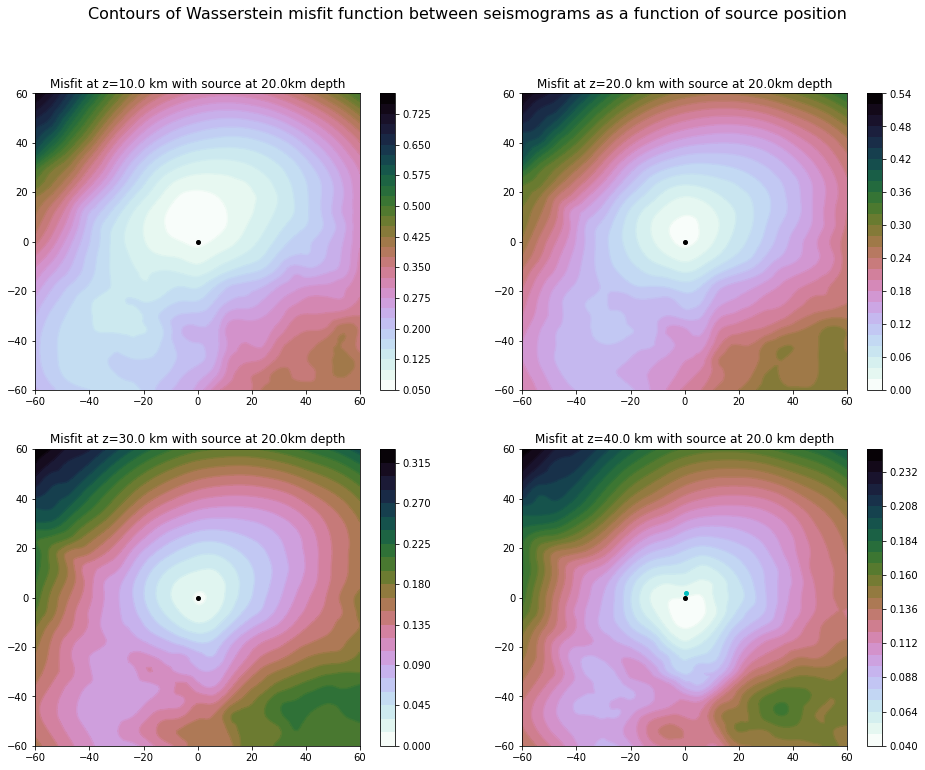

In [28]:
# plot cross sections through misfit surface
if(plotmisfit):
    if(invopt['mistype']=='OT'):
        cmt_util.plotmisfitsection(xlim,ylim,xgrid,ygrid,zg,ztrue,sol,[misfitgrid[0]],invopt,[plotfilename_t])
    else: 
        cmt_util.plotmisfitsection(xlim,ylim,xgrid,ygrid,zg,ztrue,sol,[misfitgrid],invopt,[plotfilenamel2])

This produces one of the panels in Figure 11 of Sambridge et al. (2022). 

--------------

### Repeat optimisation for different starting positions and misfit types

In [29]:
starts = [np.array([-80.,-80.,40.]),
          np.array([-80.,-80.,30.]),
          np.array([-80.,-80.,20.]),
          np.array([-80.,-80.,10.]),
          np.array([-60.,-60.,40.]),
          np.array([-60.,-60.,30.]),
          np.array([-60.,-60.,20.]),
          np.array([-60.,-60.,10.]),
          np.array([-40.,-40.,40.]),
          np.array([-40.,-40.,30.]),
          np.array([-40.,-40.,20.]),
          np.array([-40.,-40.,10.]),
          np.array([-20.,-20.,40.]),
          np.array([-20.,-20.,30.]),
          np.array([-20.,-20.,20.]),
          np.array([-20.,-20.,10.]),
          np.array([20.,20.,40.]),
          np.array([20.,20.,30.]),
          np.array([20.,20.,20.]),
          np.array([20.,20.,10.]),
          np.array([40.,40.,40.]),
          np.array([40.,40.,30.]),
          np.array([40.,40.,20.]),
          np.array([40.,40.,10.]),
          np.array([60.,60.,40.]),
          np.array([60.,60.,30.]),
          np.array([60.,60.,20.]),
          np.array([60.,60.,10.]),
          np.array([80.,80.,40.]),
          np.array([80.,80.,30.]),
          np.array([80.,80.,20.]),
          np.array([80.,80.,10.]),
          np.array([-80.,80.,40.]),
          np.array([-80.,80.,30.]),
          np.array([-80.,80.,20.]),
          np.array([-80.,80.,10.]),
          np.array([-60.,60.,40.]),
          np.array([-60.,60.,30.]),
          np.array([-60.,60.,20.]),
          np.array([-60.,60.,10.]),
          np.array([-40.,40.,40.]),
          np.array([-40.,40.,30.]),
          np.array([-40.,40.,20.]),
          np.array([-40.,40.,10.]),
          np.array([-20.,20.,40.]),
          np.array([-20.,20.,30.]),
          np.array([-20.,20.,20.]),
          np.array([-20.,20.,10.]),
          np.array([20.,-20.,40.]),
          np.array([20.,-20.,30.]),
          np.array([20.,-20.,20.]),
          np.array([20.,-20.,10.]),
          np.array([40.,-40.,40.]),
          np.array([40.,-40.,30.]),
          np.array([40.,-40.,20.]),
          np.array([40.,-40.,10.]),
          np.array([60.,-60.,40.]),
          np.array([60.,-60.,30.]),
          np.array([60.,-60.,20.]),
          np.array([60.,-60.,10.]),
          np.array([80.,-80.,40.]),
          np.array([80.,-80.,30.]),
          np.array([80.,-80.,20.]),
          np.array([80.,-80.,10.])
         ]
solutions = []

In [30]:
if(repeatoptimisations):   # Perform repeat optimisations from different starting positions. 
    if(invopt['loc']): print('\n Inverting for source location')
    if(invopt['cmt']): 
        print(' Inverting for moment tensor using gradient optimisation ')
    elif(invopt['cmt']): 
        print(' Inverting for moment tensor using linear theory')
    print(' Dimension of parameter space :',len(mstartp))
    if(invopt['precon']): 
        print(' Gradient preconditioning being used about point',invopt['mprecon'])
    if(invopt['mistype']=='OT'): print(' Misfit function: ',OTdata['Wopt'])
    if(invopt['mistype']=='L2'): print(' Misfit function: L2')
    print('\n Running optimizations.....\n')
    

    for mstart in starts:
        if(invopt['cmt'] ): mstart = np.append(mstart,cmt_util.Moment_LS([mstart[0],mstart[1],mstart[2]],prop8data)) # set initial CMT solution to best fit at starting model

        mis_start,d = cmt_util.optfunc(mstart,optdata,precon=False) # Calculate misfit for reference source

        if(invopt['loc'] and not invopt['cmt']):

            cmt_util_opt.opt_history = [mstart,mis_start,-1]
    
            # start inversion

            if(OTdata['Wopt'] == 'both'): # perform optimisation over Wu and then Wt
                OTdata['Wopt'] = 'Wt'
                optdata = {'invopt':invopt,'OTdata':OTdata,'prop8data':prop8data}
        
                opt1 = minimize(cmt_util.optfunc, mstart, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
                   options={'disp': True,'maxiter': 500},callback=recordresult)

                OTdata['Wopt'] = 'Wu'
                optdata = {'invopt':invopt,'OTdata':OTdata,'prop8data':prop8data}

                opt = minimize(cmt_util.optfunc, opt1.x, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
                       options={'disp': True,'maxiter': 500},callback=recordresult)

                OTdata['Wopt'] = 'both'
        
            else: # perform optimisation over either Wu, Wt or their average
                opt = minimize(cmt_util.optfunc, mstart, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
                       options={'disp': True,'maxiter': 500},callback=recordresult)
                        
            #print(opt)
            sol = opt.x
    
        elif(invopt['loc'] and invopt['cmt']): # Here cmt is obtained from least squares inversion at best fit source location.

            cmt_util_opt.opt_history = [mstart,mis_start,-1]


            if(invopt['precon']): mstartp = mstart/invopt['mscal'] # preconditioned starting model
            opt = minimize(cmt_util.optfunc, mstartp, optdata, jac=True, tol=1E-5*mis_start,method='L-BFGS-B',
                    options={'disp': True,'maxiter': 500},callback=recordresult)
            
            print(opt)
            sol = opt.x
            if(invopt['precon']): sol = opt.x*invopt['mscal']
            
        elif(invopt['cmt']):
    
            # start inversion

            Mxyz = cmt_util.Moment_LS([xtrue,ytrue,ztrue],optdata[0])
            Mxyz = cmt_util.buildMxyzfromupper(Mxyz)
    
            print (' Mxyz solution: \n',Mxyz)

        mis_final = opt.fun
        mfinal = sol
        print('\n Model start :',mstart,' Misfit start :',mis_start,' Misfit final :',mis_final,' Misfit true :',mis_true)
        solutions += [[mstart,mis_start,mfinal,mis_final,mtrue,mis_true,cmt_util_opt.opt_history_data[-1][4]]]
        #if(invopt['cmt']): printanalysis(sol,opt,mtrue)
        if(invopt['cmt']):cmt_util.printanalysis(sol,opt,mtrue,mstart,mis_start,mis_true,prop8data,sdata_nonoise)
        print('\n Misfit start   :',mis_start)
        print(' Misfit final     :',mis_final)
        print(' Misfit true      :',mis_true)
        r=np.array(mtrue[:3])-sol[:3]
        print(' Distance to true :',np.sqrt(np.dot(r,r)))


In [31]:
#write out pickle data for all results
if(writepicklefile):
    listOfStr = ['nx','ny','nz','xlim','ylim','zlim','nt','timestep','misfitgrid','t',
                 'sdata_nonoise','sdata_noise','true','mstart','spred_start','mis_true','mis_start',
                  'spred_final','mis_final','invopt','OTdata','prop8data','sol','opt_history','opt_history_data',
                  'xg','yg','zg','solutions']
    listOfdata = [nx,ny,nz,xlim,ylim,zlim,nt,timestep,misfitgrid,t,sdata_nonoise,
                  sdata_noise,mtrue,mstart,spred_start,mis_true,mis_start,spred_final,mis_final,
                  invopt,OTdata,prop8data,sol,cmt_util_opt.opt_history,cmt_util_opt.opt_history_data,xg,yg,zg,solutions]

    cmt_util.writepickle('pickles/'+picklefilename,listOfStr,listOfdata)

#### Analysis of convergence rates in optimisation

Here we compare convergence rates of source location from different starting points.

To read and display location only repeat solutions set `convergenceplotcmt = False`; otherwise it will read and display the location+cmt repeat solutions.

In [32]:
convergenceplots = True # plot convergence of locations from pickles file
convergenceplotcmt = False # switch to plot cmt solutions
# read in source only relocation solutions from pickle file (used in paper as Location only example)
if(convergenceplots):
    if(convergenceplotcmt):
        po = cmt_util.readpickle(readpicklefilenameOTcmt) # previous OT cmt solutions
        poL2 = cmt_util.readpickle(readpicklefilenameL2cmt) # previous L2 cmt solutions
    else: 
        po = cmt_util.readpickle(readpicklefilenameOT) # previous OT location only solutions 
        poL2 = cmt_util.readpickle(readpicklefilenameL2) # previous L2 location only solutions 


In [33]:
# plot errors in repeated solutions
if(convergenceplots): # if we haven't calculated repeat solutuons we use those in the pickle file
    solutions = po['solutions']
    i = 23 # choose a converged solution to display
    print('Distance between true and best fit solution',np.linalg.norm(po['true'][:3]-solutions[i][2][:3]))
    dlimit = 2.5  # set distance limit for convergence with location only (Gaussian noise dataset)
    if(convergenceplotcmt): dlimit = 1.0 # set distance limit for convergence cmt with optimisation in 9 d space

Distance between true and best fit solution 2.147644037160037


In [34]:
# determine which solutions using Wasserstein misfit have converged
con,d,gcon = cmt_util.checkconverge(solutions,dlimit=dlimit)
# determine which solutions from L2 misfit have converged
conL2,dL2,gconL2 = cmt_util.checkconverge(poL2['solutions'],dlimit=dlimit)

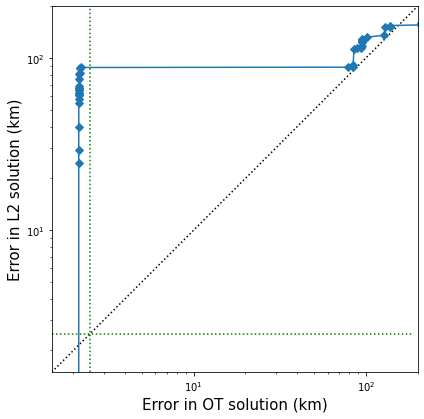

In [35]:
# convergence plot
if(convergenceplotcmt):
    d0x = 0.4
    d0y = 0.4
    d1x = 200.
    d1y = 200.
else:
    d0x = 0.5
    d0y = 0.5
    d0x = 1.5
    d0y = 1.5
    d1x = 200.
    d1y = 200.

fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(6,6))
plt.gca().set_aspect('equal')
axs.set_xlim(d0x,d1x)
axs.set_ylim(d0y,d1y)
axs.loglog([d0x,d1x],[d0y,d1y],'k:')
x = np.linspace(1,len(d),len(d))
axs.loglog([dlimit,dlimit],[d0y,d1y],'g:')
axs.loglog([d0x,185.],[dlimit,dlimit],'g:')
axs.loglog(np.sort(d),np.sort(dL2),'D-',markersize=5.)
axs.set_xlabel('Error in OT solution (km)',fontsize=15.)
axs.set_ylabel('Error in L2 solution (km)',fontsize=15.)
plt.savefig('Figures/Solution_error_L2_vs_OT_log.pdf')
plt.show()

This produces one of the panels in Figure 12 of Sambridge et al. (2022). 